# Recurrent Neural Network

In this file, we will be adressing our take on the problem using a **recurrent neural network**.

We will begin  by importing the necessary modules:

In [74]:
# General Modules
import pandas as pd
import numpy as np
from tqdm import tqdm 
import librosa
import os
import random
import pickle
import warnings
from itertools import combinations

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Neural Network
import tensorflow as tf
import keras
from keras import Sequential
from keras import regularizers as reg
from keras import layers

# Useful data and metrics 
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix
from scipy.io import wavfile as wav

warnings.filterwarnings('ignore')

## Data Analysis and Preprocessing

In [75]:
df = pd.read_csv('../UrbanSound8K/metadata/UrbanSound8K.csv')

df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


As per mentioned in the **project statement**, the target variable corresponds to the correct labeling of the sound. There are 10 different possible sounds in the dataset:

 - air conditioner
 - car horn
 - children playing
 - dog bark
 - drilling
 - engine idling
 - gun shot
 - jackhammer
 - siren
 - street music


We can already find the `classID` column, which essentially represents each label as an integer, from 0 to 9:


In [76]:
class_id_pairs = df[['classID', 'class']].drop_duplicates().sort_values(by="classID")

for index, row in class_id_pairs.iterrows():
    print(f'classID: {row["classID"]}, class: {row["class"]}')

classID: 0, class: air_conditioner
classID: 1, class: car_horn
classID: 2, class: children_playing
classID: 3, class: dog_bark
classID: 4, class: drilling
classID: 5, class: engine_idling
classID: 6, class: gun_shot
classID: 7, class: jackhammer
classID: 8, class: siren
classID: 9, class: street_music


This means that we can remove the last column and begin working with our dataset, which we already determined is slightly unbalanced for the `car_horn` and `gunshot` values: 

In [77]:
df.drop(columns=['class'],inplace=True)
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2


Before proceeding, we decided to check if our dataset is imbalanced.

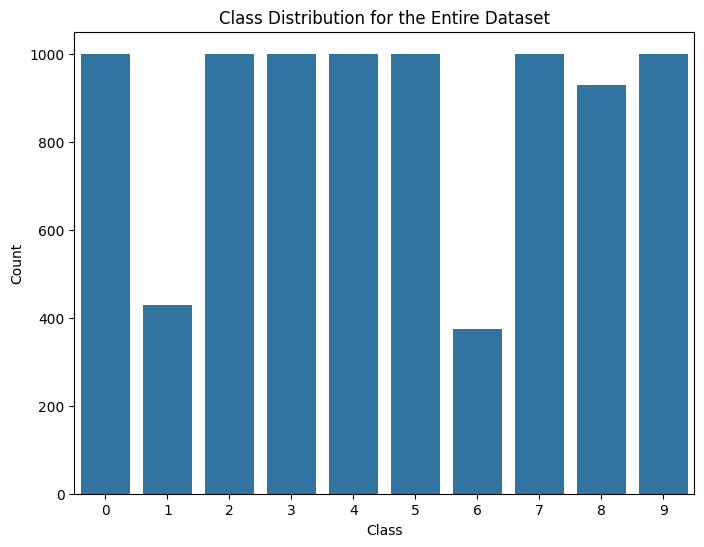

In [78]:
plt.figure(figsize=(8, 6))
sns.countplot(x=df['classID'])  
plt.title("Class Distribution for the Entire Dataset")
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Classes of ID 1 and 6 show significant imbalance, when compared to other classes' counts. 

No over or under sampling techniques will be applied throghout this notebook, but imbalance was taken into consideration while evaluating each model's performance.

## Feature Extraction


The **librosa** library has a built-in method for feature extraction, called [Mel-Frequency Cepstral Coefficients](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum), that summarises the frequency distribution across the time window.

In order to build the new dataset, we developed the following functions, which are capable of extracting **1D or 2D** features.

These feature extractor functions will represent the frequencies found in the wav files as **np arrays**, while using MFCCs in order to obtain features similar to the way humans perceive sounds.

In [135]:
# Uses the mean from the Time axis, uses file sample rate
def features_extractor_1D(file):
    audio, sample_rate = librosa.load(file) 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0) 
    return mfccs_scaled_features

# Uses both Time and Frequency axis, custom sample rate
def features_extractor_2D(file, sample_rate, path=True):
    if path: audio, _ = librosa.load(file) 
    else: audio = file
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    return mfccs_features


# Extracts Mel-Spectrogram instead of MFCC's (2nd model)
def features_extractor_spectro(file, sample_rate, path=True):
    mel_spectrogram = librosa.feature.melspectrogram(
        y=file, 
        sr=sample_rate, 
        n_mels=128,               
        fmin=0,                   
        fmax= sample_rate / 2) # Recommended by documentation 
        
    # Convert to Log-Mel-Spectrogram
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    return log_mel_spectrogram

Now that we know how to transform audio files into usable data types, we must associate each extracted numpy array to their respective entry inside the `df` dataframe.

This will allow for **important pre-processing steps** to be applied accordingly, as well as **proper Neural Network training and testing**.

## Data Preprocessing

The function below identifies files and normalizes them to be 4 seconds long for consistency.

It is capable of identifying `.wav` files with duration != 4s, and apply padding or truncating, depending on each file's issue:

In [136]:
def zero_padding(file_path, target_sr=44100, target_length=4):
    y, sr = librosa.load(file_path, sr=target_sr)
    target_samples = int(target_length * sr)
    
    if len(y) > target_samples:
        # Trim the audio to the target length
        y = y[:target_samples]
    else:
        # Pad the audio with silence to reach the target length
        padding = target_samples - len(y)
        y = np.pad(y, (0, padding), 'constant')
    return y

In order to improve dataset consistency and traning data quality, we also decided to create 2 new datasets, which we saved in pickle files in order to avoid running this code each time we needed the dataframes: 

 - `df_22`: resamples data to 22050Hz
 - `df_44`: resamples data to 44100Hz

During the development of this function, after extraction, we realized that the resulting dataframe displayed varying ranges of values.

To address this issue, we decided to apply `scaling` and `zero padding` **not to the new dataframes**, but **directly into the extracted numpy arrays**, in order to easily and efficiently improve data quality and consistency for our modeling purposes. In other words, these steps are automatically applied during the extraction process.

The group decided to use **MinMax scaling**, since it normalizes data while preserving integrity, rendering the method ideal for our Neural Network use case.

The data extraction loop has been placed inside this markdown cell, in order to prevent it from automatically running when not necessary:

---

```py
# Identify path containing all folds
audio_dataset_path='../UrbanSound8K/audio/'
extracted_features22=[]
extracted_features44=[]

scaler = MinMaxScaler(feature_range=(-1, 1))


# Iterates over all original dataframe rows (predicts approximate runtime)
for index_num,row in tqdm(df.iterrows(), total=len(df), desc="Processing", unit="row"):
    
    # Linux Version
    #file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))

    # Windows Version
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'\\',str(row["slice_file_name"]))
    
    # Adds associated sound label
    final_class_labels = row["classID"]

    y = zero_padding(file_name)

    # 22050Hz sample rate
    data1=features_extractor_2D(y, 22050, False) 
    data1_scaled = scaler.fit_transform(data1)
    extracted_features22.append([data1_scaled, final_class_labels])

    # 44100hHz sample rate Mel-Spectrograms
    data2=features_extractor_spectro(y, 44100, False) 
    data2_scaled = scaler.fit_transform(data2)
    extracted_features44.append([data2_scaled, final_class_labels])
    
# Convert extracted_features to Pandas dataframe
df_22 = pd.DataFrame(extracted_features22,columns=['feature','class'])
df_44 = pd.DataFrame(extracted_features44,columns=['feature','class'])

# Save dataframes as pickle files
df_22.to_pickle("rnn_2d_22.pkl")
df_44.to_pickle("rnn_2d_44.pkl")
```
---

In [137]:
# Identify path containing all folds
audio_dataset_path='../UrbanSound8K/audio/'
extracted_features22=[]
extracted_features44=[]

scaler = MinMaxScaler(feature_range=(-1, 1))


# Iterates over all original dataframe rows (predicts approximate runtime)
for index_num,row in tqdm(df.iterrows(), total=len(df), desc="Processing", unit="row"):
    
    # Linux Version
    #file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))

    # Windows Version
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'\\',str(row["slice_file_name"]))
    
    # Adds associated sound label
    final_class_labels = row["classID"]

    y = zero_padding(file_name)

    # 22050Hz sample rate
    #data1=features_extractor_2D(y, 22050, False) 
    #data1_scaled = scaler.fit_transform(data1)
    #extracted_features22.append([data1_scaled, final_class_labels])

    # 44100hHz sample rate Log Mel-Spectrograms
    data2=features_extractor_spectro(y, 44100, False) 
    data2_scaled = scaler.fit_transform(data2)
    extracted_features44.append([data2_scaled, final_class_labels])
    
# Convert extracted_features to Pandas dataframe
#df_22 = pd.DataFrame(extracted_features22,columns=['feature','class'])
df_44 = pd.DataFrame(extracted_features44,columns=['feature','class'])

# Save dataframes as pickle files
#df_22.to_pickle("rnn_2d_22.pkl")
df_44.to_pickle("rnn_2d_44.pkl")

Processing: 100%|██████████| 8732/8732 [01:46<00:00, 82.26row/s] 


In [138]:
# Pickle avoids constant running of feature extraction

# Extracted data (22050Hz)
df_22 = pd.read_pickle('../rnn_2d_22.pkl')

df_22.head()

,feature,class
0,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0...",3
1,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2
2,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2
3,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2
4,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2


In [139]:
# Extracted data (44100Hz Mel-Spectrograms)
df_44 = pd.read_pickle('./rnn_2d_44.pkl')

df_44.head()

,feature,class
0,"[[-0.64049625, -0.7265742, -0.7773571, -0.6142...",3
1,"[[0.8535352, 0.98622537, 0.9999999, 0.9665215,...",2
2,"[[0.91045505, 0.62650007, 0.73601735, 0.950054...",2
3,"[[0.9126251, 0.96015954, 0.9554943, 0.53234553...",2
4,"[[0.9469551, 0.99999994, 1.0000001, 0.8682727,...",2


## Avoiding common pitfalls

The original [UrbanSound8k](https://urbansounddataset.weebly.com/urbansound8k.html) website features a section outlined specifically for **cross validation**.

These rules emphasize the specific creation of 10 folds, following the identifiers present in the `fold` column from the original csv. It is explained that different folds display different levels of classification difficulty, which could potentially invalidate model efficiency if not performed correctly. 

Since both the `df_44` and `df_22` dataframes were created using the row order of the df_dataframe, we know that the `fold` column will be correctly aligned with the rest of the data. This means that we can select specific rows and assing them to their respective fold:

In [140]:
df_22['fold'] = df['fold']

df_22.head()

,feature,class,fold
0,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0...",3,5
1,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2,5
2,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2,5
3,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2,5
4,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2,5


In [141]:
df_44['fold'] = df['fold']

df_44.head()

,feature,class,fold
0,"[[-0.64049625, -0.7265742, -0.7773571, -0.6142...",3,5
1,"[[0.8535352, 0.98622537, 0.9999999, 0.9665215,...",2,5
2,"[[0.91045505, 0.62650007, 0.73601735, 0.950054...",2,5
3,"[[0.9126251, 0.96015954, 0.9554943, 0.53234553...",2,5
4,"[[0.9469551, 0.99999994, 1.0000001, 0.8682727,...",2,5


## Model Development

In order to develop an effective **Recurrent Neural Network**, the group decided to explore the concept of **Long Short Term Memory** (LSTM) networks. LSTMs are a type of RNN that are designed to handle sequential data pattern recognition. 

We consider this approach could be the most effective in order to classify the sounds, since continuous sounds or repetitive rythms are sequential. These time-dependant aspects are characteristics which LSTMs are capable of recognizing and "remembering" throughout the entire training process.

LSTMs are capable of assigning weights to "remembered" features, allowing them to **balance the importance** of **older** and **more recent** information, ensuring they do not give more importance to either one.

#### Neural Network Architecture

In order to build this LSTM model, we decided to do some research and attempt to look into the topology suggested in a few published papers, before attempting to change and improve classification performance.

The [first paper](https://dergi.neu.edu.tr/index.php/aiit/article/download/740/327/3147) suggests the following:

 - MFCC
 - 22050Hz sample rate
 - 1 LSTM layer of size 128
 - followed another LSTM layer of size 64
 - Dropout Rate = 0.2
 - SoftMax for prediction
 - 50 epochs
 - Adam optimization
 
This topology takes the large input vector size into consideration, meaning that it should maintain robustness and generally avoid major overfiting, while still allowing the model to identify patterns during an appropriate ammount of time. It also uses as sufficiently good sound quality for environment noise purposes, although we would like to verify if the difference in sound quality allows for better classification. A dropout rate of 0.2 (rate in which neurons are randomly disabled) is used in order to prevent overfitting.

Overall, this model aims for efficiency and computation speed, in an effort to reduce training time while preserving model quality and performance, hence why we chose this as our starter model topology. 


[The second paper](https://annals-csis.org/Volume_18/drp/pdf/185.pdf) proposes almost identical topology (similar to most of the projects found), with the small changes of:

 - Mel-Spectrogram
 - 44100Hz sample rate
 - Dropout Rate = 0.25
 - 64 epochs

We expect this model to take longer to train (due to the higher number of epochs).
It could lead to overfitting, which is why the **dropout rate** has also been **adjusted** to the slightly higher value of 0.25. If it is correctly trained, it **should demonstrate better results**, compared to the previous settings.

Overall, it is a generally "riskier" model, and it was chosen to assess if the results of the combination of **increase in epochs** and **improved sound quality** could compensate the time consumed, render the training problems relativelly irrelevant if the generalization and classification abilities of the resulting model show significant improvements.

# NEEDS REVISION

### Model Performance Predictions


We expect the **first model** to be trained faster due to inferior sound quality and lower epochs, in contrast with the **second model**, which could overfit but benefits from higher sound quality and dropout rate, potentially mitigating such problems, overall being preferable.

Both results will be used as a type of foundation for the final topology decisions.

### Model Generation

Following the previously stated network topology and parameters, and using the available **tensorflow** and **keras** modules, we can start implementing an LSTM neural network, using available tools like:

 - `keras.Sequential()`
 - `layers.LSTM` 
 - `layers.Dropout`
 - `layers.TimeDistributed`
 - `layers.Dropout`

We have created a Neural Network generating function, which is based on the following concepts: 

 - By ensuring that the input has a fixed shape and frequency, we can now use a Sequential keras model. This will allow for simple layer stacking and parameter configuration;
 - A dropout rate of 0.2 is employed in between each layer (with the exception of flatten and classification layers);
 - Time Distributed layers allow for easier handling of the extracted sequential features, by preserving the sequential time dependant features while reducing dimensionality;
 - In order to potentially improve our classifier's robustness, we decided to employ **l2 regularization** (or Lasso regularization), due to our dataset's reduced size;



In [142]:
# Easily configurable to generate with different architecture
# Implicitly creates first model, explained above

def generate_lstm(train_shape, lstm1_size=128, lstm2_size=64, dropout=0.2, regularization=0.01):
    # Initiaizes sequential model
    model = Sequential()

    # Adds 2 LSTM layers of size 128 and 64, with a dropout rate of 0.2
    model.add(layers.LSTM(lstm1_size,  input_shape = train_shape, return_sequences = True, activation='tanh'))
    model.add(layers.Dropout(dropout))
    model.add(layers.LSTM(lstm2_size, return_sequences = True, activation='tanh'))
    model.add(layers.Dropout(dropout))

    # Suggested intermediate dense layer -> reduce dimensionality and preserve time sequential features
    model.add(layers.TimeDistributed(layers.Dense(64, activation='tanh', kernel_regularizer = reg.l2(regularization))))
    model.add(layers.Dropout(dropout))
    model.add(layers.TimeDistributed(layers.Dense(32, activation='tanh', kernel_regularizer = reg.l2(regularization))))
    model.add(layers.Dropout(dropout))

    # Last TimeDistributed produces 16 features/time step (thought dimensionality was appropriate)
    model.add(layers.TimeDistributed(layers.Dense(16, activation='tanh', kernel_regularizer = reg.l2(regularization))))
    model.add(layers.Dropout(dropout))

    # Flattens the last TimeDistributed outputs
    model.add(layers.Flatten())

    # Dense output layer -> classification
    model.add(layers.Dense(10, activation = 'softmax'))

    return model

## Data Splitting

In order to define X and y while respecting the UrbanSound8k website indications, we need to use 9 folds for building (X_train, y_train) and the remaining fold as (X_test, y_test), in the 10 different possible ways. 

However, since we must have an independent validation set for the 10-fold cross-validation strategy to adjust parameters during training, and considering  that would elevate the possible combinations to 45 instead of 10, we decided to implement a different approach:

 1. Define the 9 training sets
 2. Define the test set
 3. Randomly choose 1 of the training sets to be used as validation set

This enables the possibility of choosing how many times we want to run the data with different test and validation folds, in a systematic, simple way.

It is also a guarantee that the **train, validation and test data are all independent**!


The function will also be used for ease of data shape visualization, as explained below:

In [143]:
def train_test_validation_split(df, i, values_log=False, full_log=False, distribution=False):
    # Rows where "fold" is not i -> different training combinations
    train_dataframe = df[df["fold"] != i]  
    
    # Rows where "fold" is i -> different testing combinations
    test_dataframe = df[df["fold"] == i]  

    # Enumerates every fold number in the current train_dataframe
    train_folds = [fold for fold in range(1, 11) if fold != i]

    # Which allows us to randomly select one of those folds -> validation fold
    validation_fold = random.choice(train_folds)

    # Create validation dataframe in order to extract validation X and y
    validation_dataframe = train_dataframe[train_dataframe["fold"] == validation_fold]

    # Update train_dataframe
    train_dataframe = train_dataframe[train_dataframe["fold"] != validation_fold]

    # Split the dataset into training features and class
    X_train = np.array(train_dataframe['feature'].tolist())
    y_train = np.array(train_dataframe['class'].tolist())

    # Split the dataset into testing features and class
    X_test = np.array(test_dataframe['feature'].tolist())
    y_test = np.array(test_dataframe['class'].tolist())

    # Split the dataset into validation features and class
    X_val = np.array(validation_dataframe['feature'].tolist())
    y_val = np.array(validation_dataframe['class'].tolist())

    # Labels must be one hot encoded for the LSTM output layer
    y_train_encoded = keras.utils.to_categorical(y_train, num_classes=10)
    y_test_encoded = keras.utils.to_categorical(y_test, num_classes=10)
    y_val_encoded = keras.utils.to_categorical(y_val, num_classes=10)


    # Outputs detailed information
    if full_log: 
        print(f"Training Dataset: {X_train.shape} samples, {X_train.shape[1:]} per sample")
        print(f"Training Labels (Before Encoding): {y_train.shape}")
        print(f"Training Labels (After Encoding): {y_train_encoded.shape} (Samples: {y_train_encoded.shape[0]}, Classes: {y_train_encoded.shape[1]})")

        print(f"Testing Dataset: {X_test.shape} samples, {X_test.shape[1:]} per sample")
        print(f"Testing Labels (Before Encoding): {y_test.shape}")
        print(f"Testing Labels (After Encoding): {y_test_encoded.shape} (Samples: {y_test_encoded.shape[0]}, Classes: {y_test_encoded.shape[1]})")

        print(f"Validation Dataset: {X_val.shape} samples, {X_val.shape[1:]} per sample")
        print(f"Validation Labels (Before Encoding): {y_val.shape}")
        print(f"Validation Labels (After Encoding): {y_val_encoded.shape} (Samples: {y_val_encoded.shape[0]}, Classes: {y_val_encoded.shape[1]})")
        print("=" * 85)

    # Outputs simple information
    elif values_log:
        print(f"X_train: {X_train.shape}")
        print(f"y_train_encoded: {y_train_encoded.shape}")
        print(f"X_test: {X_test.shape}")
        print(f"y_test_encoded: {y_test_encoded.shape}")
        print(f"X_val: {X_val.shape}")
        print(f"y_val_encoded: {y_val_encoded.shape}")
        print("-" * 85)

    # Outputs class distribution graph of each fold
    elif distribution:
        plt.figure(figsize=(8, 6))
        sns.countplot(x=y_test)  
        plt.title(f"Class Distribution for Fold {i}")
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.show()

    return X_train, y_train_encoded, X_test, y_test_encoded, X_val, y_val_encoded


Let's visualize our train and test data shapes, as well as class distribution for every combination:

In [144]:
# First Dataframe
for i in range(1,11):
    X_train, y_train, X_test, y_test, X_val, y_val = train_test_validation_split(df_22, i, values_log=True)

X_train: (7036, 40, 345)
y_train_encoded: (7036, 10)
X_test: (873, 40, 345)
y_test_encoded: (873, 10)
X_val: (823, 40, 345)
y_val_encoded: (823, 10)
-------------------------------------------------------------------------------------
X_train: (6919, 40, 345)
y_train_encoded: (6919, 10)
X_test: (888, 40, 345)
y_test_encoded: (888, 10)
X_val: (925, 40, 345)
y_val_encoded: (925, 10)
-------------------------------------------------------------------------------------
X_train: (6969, 40, 345)
y_train_encoded: (6969, 10)
X_test: (925, 40, 345)
y_test_encoded: (925, 10)
X_val: (838, 40, 345)
y_val_encoded: (838, 10)
-------------------------------------------------------------------------------------
X_train: (6936, 40, 345)
y_train_encoded: (6936, 10)
X_test: (990, 40, 345)
y_test_encoded: (990, 10)
X_val: (806, 40, 345)
y_val_encoded: (806, 10)
-------------------------------------------------------------------------------------
X_train: (6973, 40, 345)
y_train_encoded: (6973, 10)
X_test:

In [145]:
# Second Dataframe
for i in range(1,11):
    X_train, y_train, X_test, y_test, X_val, y_val = train_test_validation_split(df_44, i, values_log=True)

X_train: (7021, 128, 345)
y_train_encoded: (7021, 10)
X_test: (873, 128, 345)
y_test_encoded: (873, 10)
X_val: (838, 128, 345)
y_val_encoded: (838, 10)
-------------------------------------------------------------------------------------
X_train: (7006, 128, 345)
y_train_encoded: (7006, 10)
X_test: (888, 128, 345)
y_test_encoded: (888, 10)
X_val: (838, 128, 345)
y_val_encoded: (838, 10)
-------------------------------------------------------------------------------------
X_train: (6817, 128, 345)
y_train_encoded: (6817, 10)
X_test: (925, 128, 345)
y_test_encoded: (925, 10)
X_val: (990, 128, 345)
y_val_encoded: (990, 10)
-------------------------------------------------------------------------------------
X_train: (6905, 128, 345)
y_train_encoded: (6905, 10)
X_test: (990, 128, 345)
y_test_encoded: (990, 10)
X_val: (837, 128, 345)
y_val_encoded: (837, 10)
-------------------------------------------------------------------------------------
X_train: (6923, 128, 345)
y_train_encoded: (6923

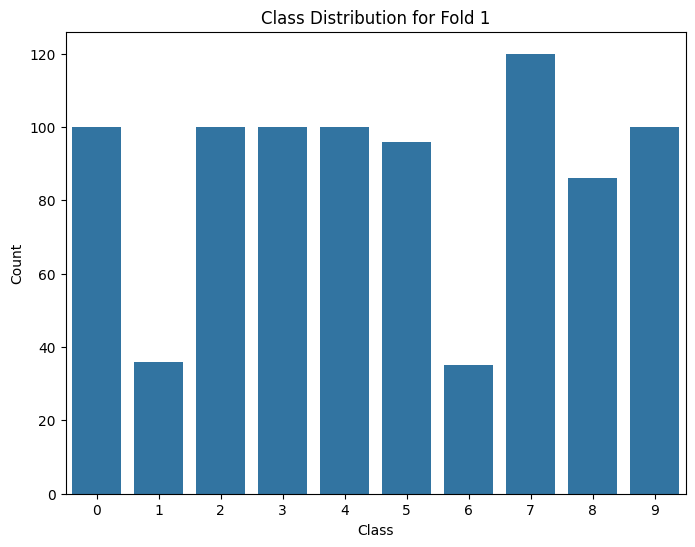

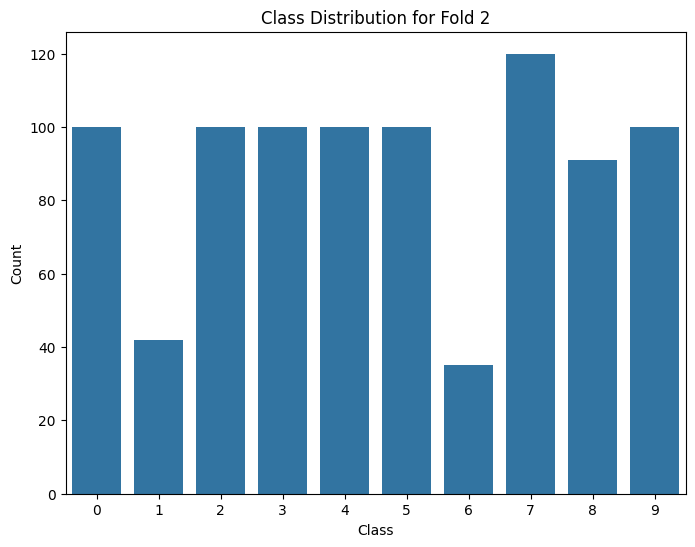

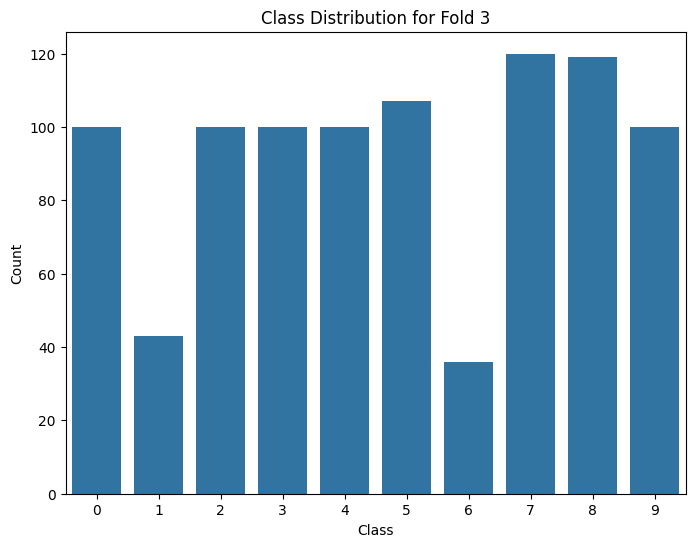

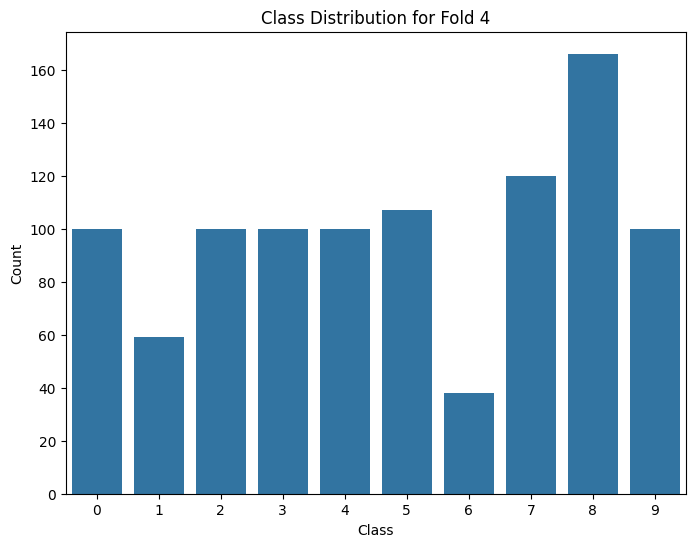

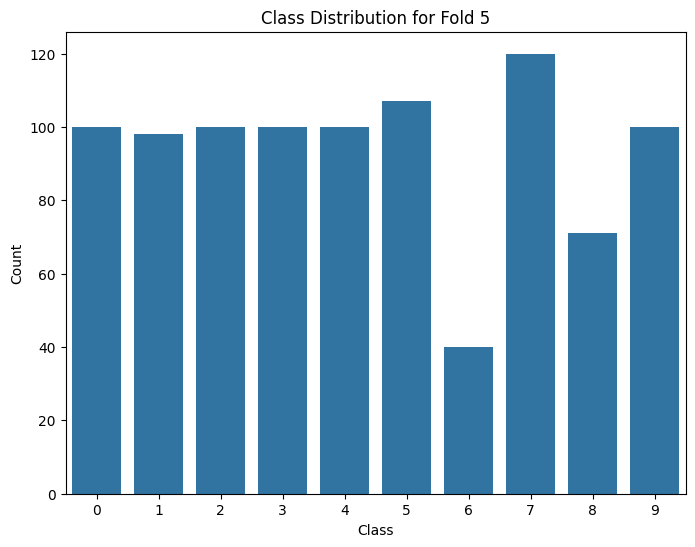

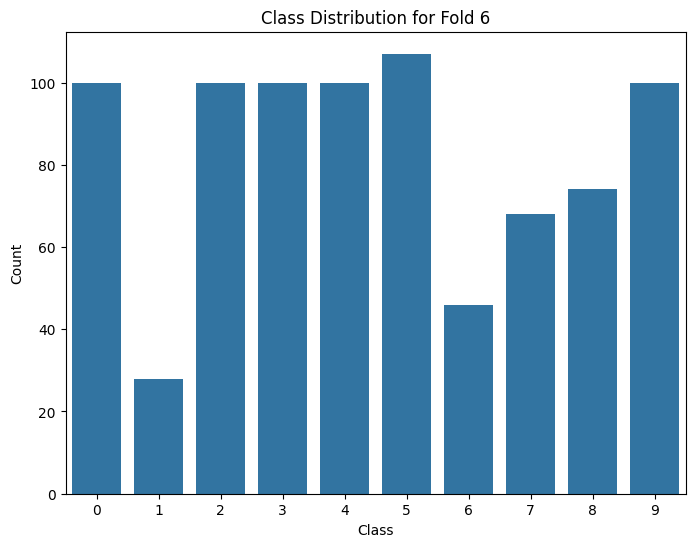

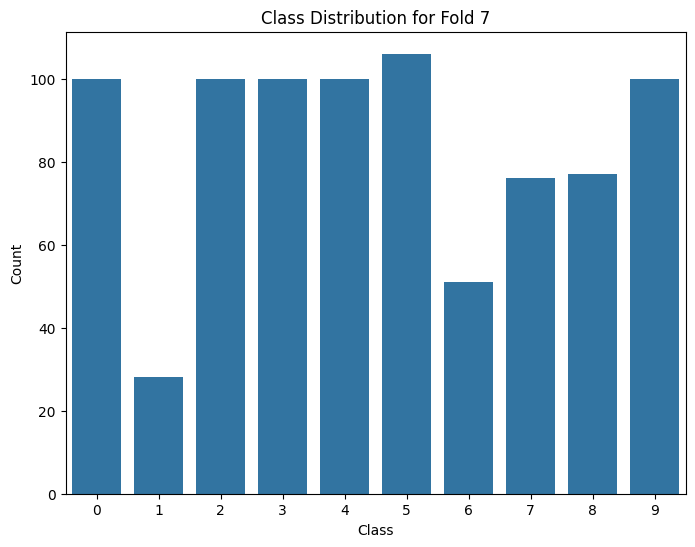

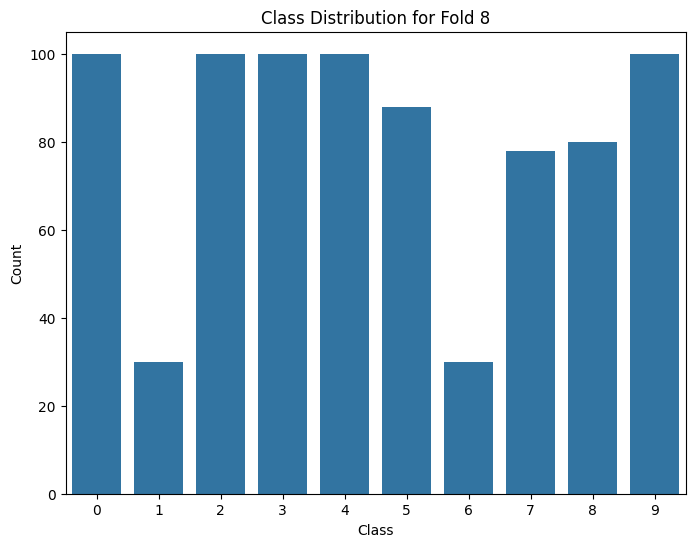

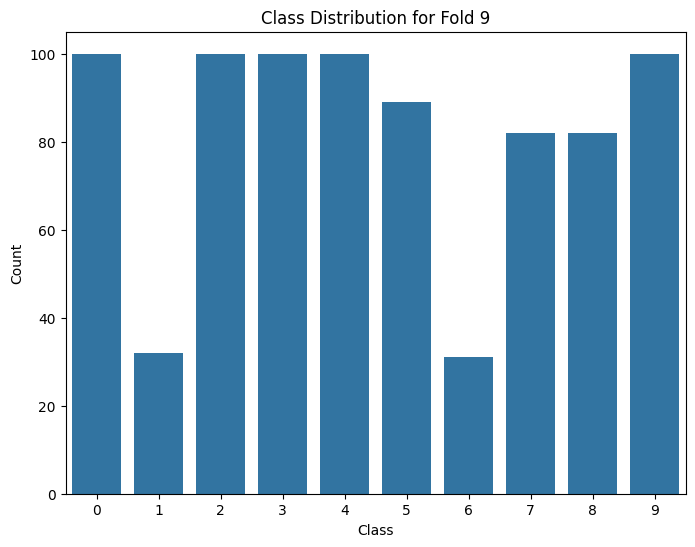

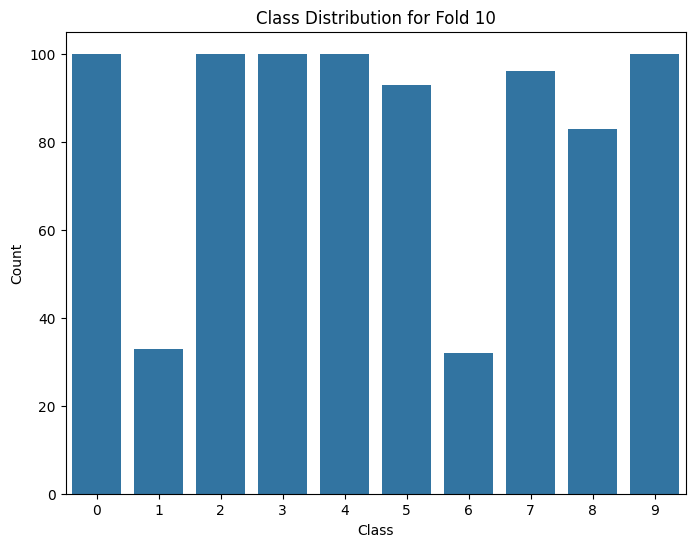

In [146]:
# Class counts visualization (allows for balance comparison)
for i in range(1,11):
    X_train, y_train, X_test, y_test, X_val, y_val = train_test_validation_split(df_44, i, distribution=True)

A slight class imbalance is identifiable in all folds. Classes 1 and 6 are consistently the minority, just like in the original dataframe.

## Model Performance

The LSTM's input dimensions are determined by the shape of our data. As you can confirm in the print statement above, our shapes' first index are not constant in each fold, but they display a consistent structure:

  - `batch_size`: Number of samples in the set (7859, 7844...)
  - `time_steps`: Number of time steps in the data (40 for the first dataframe, 128 for the second dataframe)
  - `n_features`: Number of features at each time step (always 345)

Furthermore, we must build our model using the following:

  - **input_shape** = (time_steps, n_features)

Which directly corresponds to:

In [147]:
SHAPE1 = (40, 345)
SHAPE2 = (128, 345)

And creates models with the following architectures:

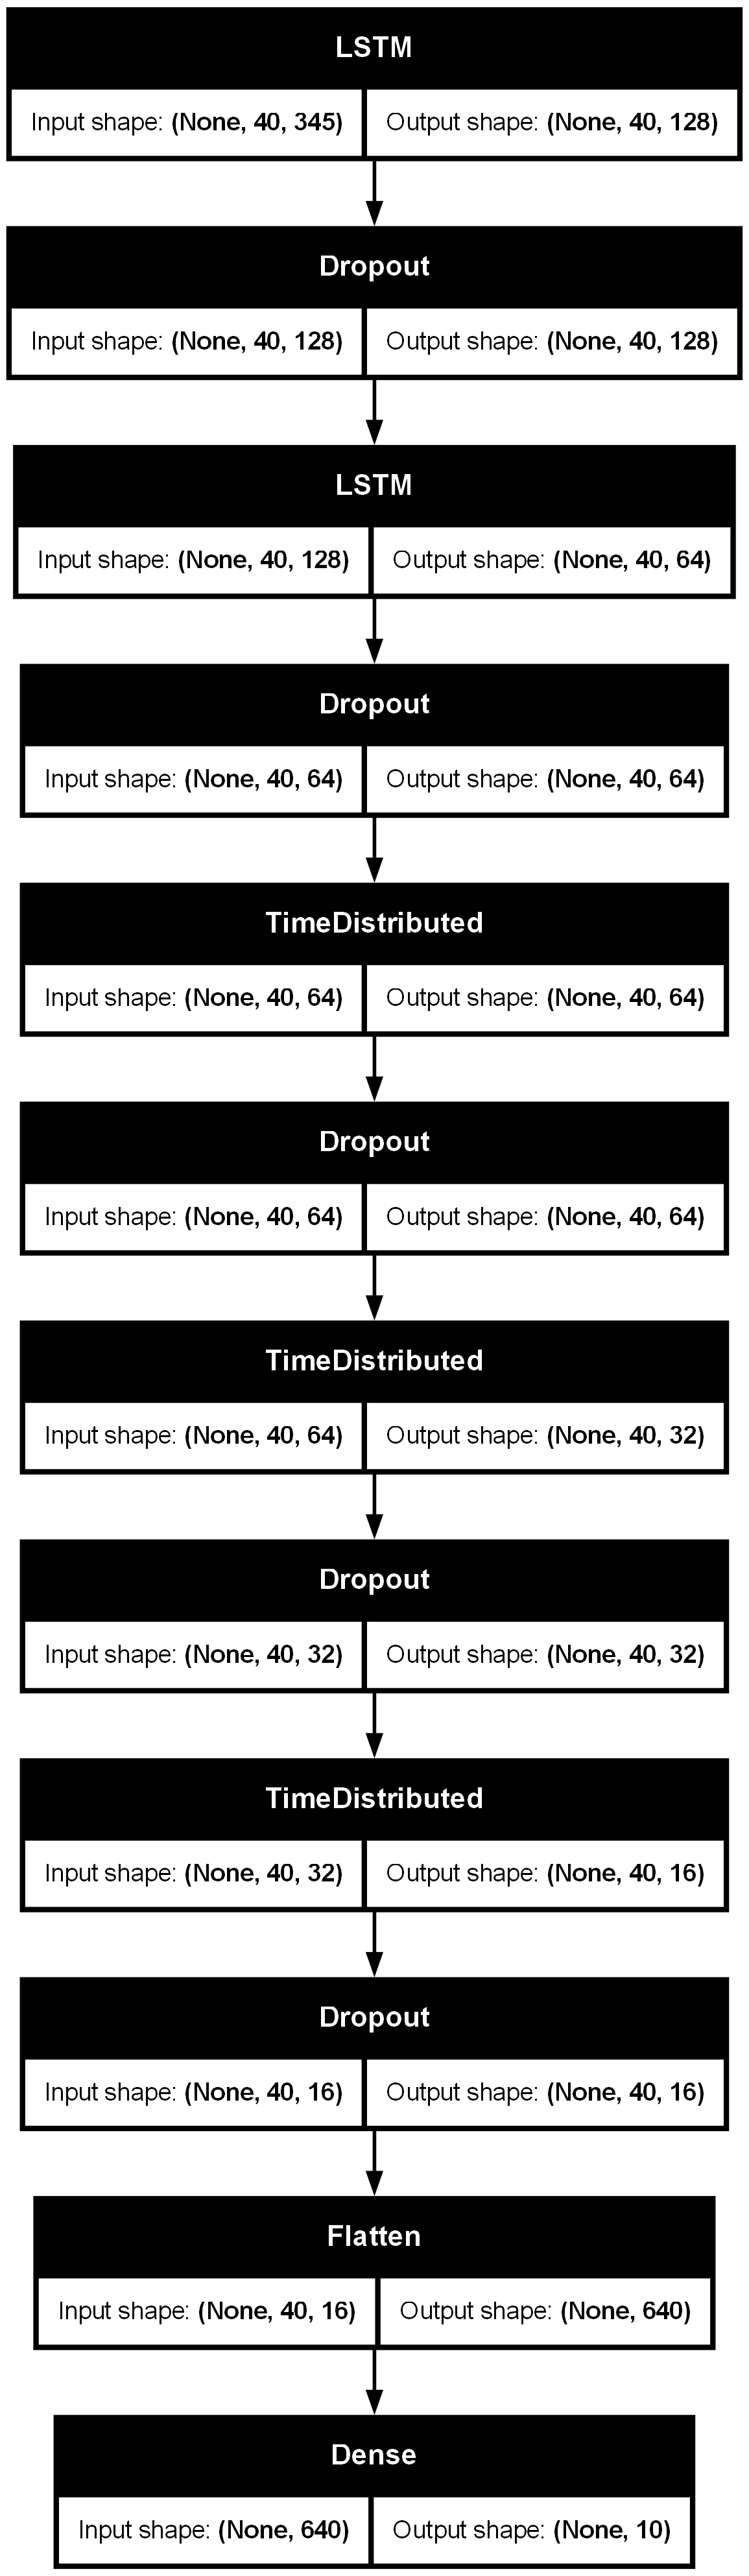

In [148]:
model_for_image = generate_lstm(SHAPE1)

keras.utils.plot_model(model_for_image, "model.png", show_shapes=True)

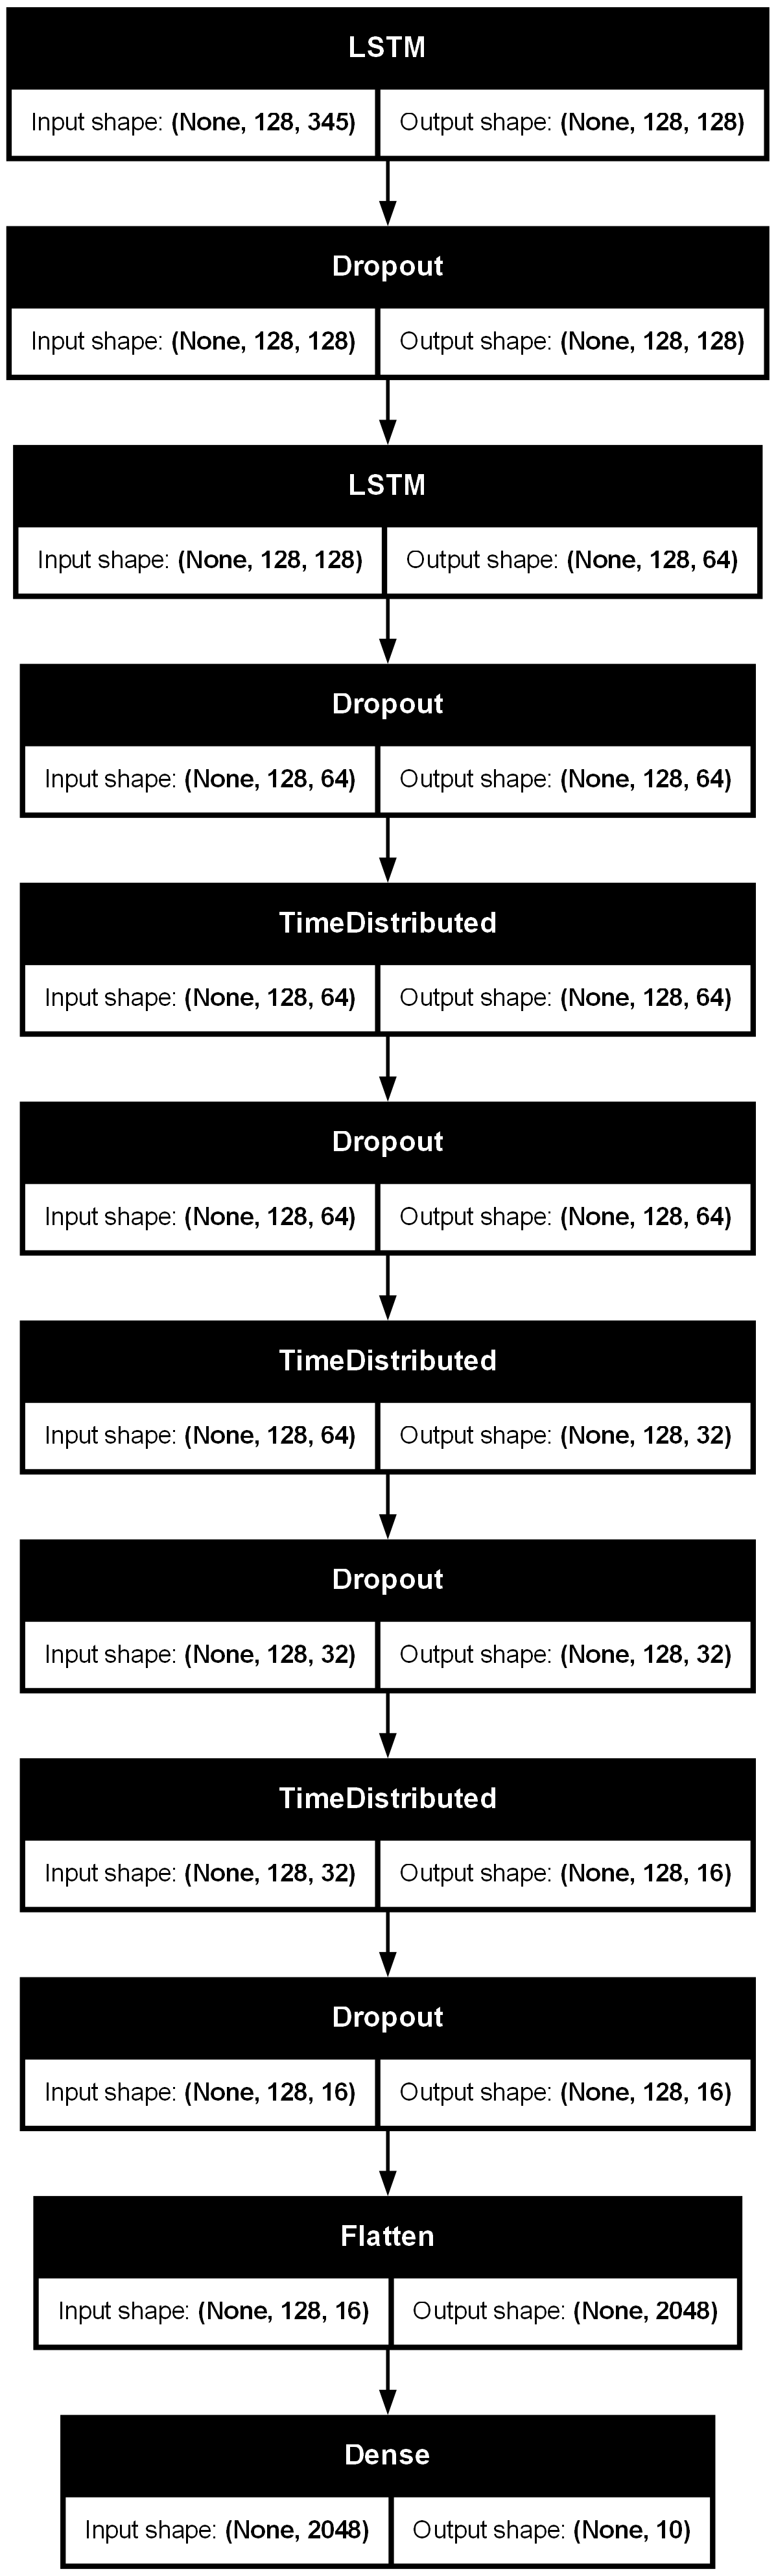

In [149]:
model_for_image = generate_lstm(SHAPE2)

keras.utils.plot_model(model_for_image, "model.png", show_shapes=True)

In order to facilitate the testing different neural network architectures, we decided to build a complete and easily customizable function that returns useful performance data:

In [150]:
OPTIMIZER = 'adam'
LOSS = 'categorical_crossentropy'
METRICS = ['accuracy']

def test_model(dataframe, input_shape=(40,345), epochs=50, dropout=0.2, regularization=0.01, batch_size=32, begin=1, end=11):
    
    # Stores performance metrics for each fold
    # index = fold (i) - 1
    accuracy_list = []
    loss_list = []
    f1_list = []  
    confusion_matrix_list = []

    # Weighted accuracy due to slight class imbalance
    weighted_accuracy_list = []  

    training_accuracy_list = []

    # Relative to the validation fold
    v_accuracy_list = []

    # Gets predictions
    predictions_list = []
    true_y_list = []

    # Test for every combination possible
    for i in range(begin,end):

        print(f"Test fold {i}")

        # Defines train-test-validation split
        X_train, y_train, X_test, y_test, X_val, y_val = train_test_validation_split(dataframe, i)

        # Creates fresh model
        model = generate_lstm(input_shape, dropout=dropout, regularization=regularization)

        # Compiles the model
        model.compile(optimizer = OPTIMIZER,
                      loss = LOSS, 
                      metrics = METRICS) 

        # Trains the model
        epoch_data = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = epochs, batch_size=batch_size)  

        # Extract the final training accuracy from the history
        train_accuracy = epoch_data.history['accuracy'][-1]  
        val_accuracy = epoch_data.history['val_accuracy'][-1]
        
        # Obtains simple performance metrics (accuracy and loss)
        results = model.evaluate(X_test, y_test, verbose=0)
        fold_loss, fold_accuracy = results[0], results[1]

        # Gets model predictions (converts one-hot back to numerical)
        y_pred = model.predict(X_test).argmax(axis=1)
        y_true = y_test.argmax(axis=1)

        # F1 score
        f1 = f1_score(y_true, y_pred, average='weighted')

        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred)
        
        # weighted_accuracy weights based on y_test from the current fold
        class_weights = compute_class_weight('balanced', classes=np.unique(y_true), y=y_true)
        class_weight_dict = dict(zip(np.unique(y_true), class_weights))

        # Weighted accuracy
        weighted_accuracy = np.average(y_pred == y_true, weights=[class_weight_dict[cls] for cls in y_true])

        # Adds results to the lists
        accuracy_list.append(fold_accuracy)
        loss_list.append(fold_loss)
        f1_list.append(f1)
        weighted_accuracy_list.append(weighted_accuracy)
        training_accuracy_list.append(train_accuracy)
        confusion_matrix_list.append(conf_matrix)
        predictions_list.append(y_pred)
        true_y_list.append(y_true)
        v_accuracy_list.append(val_accuracy)

    return [accuracy_list, loss_list, f1_list, weighted_accuracy_list, training_accuracy_list, v_accuracy_list, confusion_matrix_list, predictions_list, true_y_list]


### First Model

This model will use the architecture outlined in the first paper:

```py
# Runs all folds
results = test_model(df_22, SHAPE1)

# Save the results to a pickle file for initial plotting
with open('results_22050.pkl', 'wb') as f:
    pickle.dump(results, f)
```

In [153]:

# Load the 2D array from the pickle file
with open('./pickle_jar/results_22050.pkl', 'rb') as file:
    results = pickle.load(file)

confusion_matrix_list = results[6]
                                                                                                                   
predictions_list, true_y_list = results[7:9]

In [154]:
def print_results(results):
    # Split results into variables
    accuracy_list, loss_list, f1_list, weighted_accuracy_list, training_accuracy_list, validation_accuracy_list = results[0:6]

    # Calculate Average and Standard Deviation for Metrics
    avg_accuracy = np.mean(accuracy_list)
    std_accuracy = np.std(accuracy_list)

    avg_loss = np.mean(loss_list)
    std_loss = np.std(loss_list)

    avg_f1 = np.mean(f1_list)
    std_f1 = np.std(f1_list)

    avg_weighted_accuracy = np.mean(weighted_accuracy_list)
    std_weighted_accuracy = np.std(weighted_accuracy_list)

    avg_training_accuracy = np.mean(training_accuracy_list)
    std_training_accuracy = np.std(training_accuracy_list)

    avg_validation_accuracy = np.mean(validation_accuracy_list)
    std_validation_accuracy = np.std(validation_accuracy_list)


    # Print Final Metrics Across All Folds (4 decimal)
    print("\nFinal Metrics Across All Folds:\n\n")

    print("Loss and F1 score: \n")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Loss Standard Deviation: {std_loss:.4f}")

    print(f"Average F1 Score (Weighted): {avg_f1:.4f}")
    print(f"F1 Score Standard Deviation: {std_f1:.4f}")

    print("\nAccuracies: \n")
    print(f"Average Training Accuracy: {avg_training_accuracy:.4f}")
    print(f"Training Accuracy Standard Deviation: {std_training_accuracy:.4f}")

    print(f"Average Validation Accuracy: {avg_validation_accuracy:.4f}")
    print(f"Training Validation Standard Deviation: {std_validation_accuracy:.4f}")

    print(f"Average Test Accuracy: {avg_accuracy:.4f}")
    print(f"Test Accuracy Standard Deviation: {std_accuracy:.4f}")

    print(f"Average Weighted Accuracy: {avg_weighted_accuracy:.4f}")
    print(f"Weighted Accuracy Standard Deviation: {std_weighted_accuracy:.4f}")

    return accuracy_list, weighted_accuracy_list

In [155]:
accuracy_list, weighted_accuracy_list = print_results(results)


Final Metrics Across All Folds:


Loss and F1 score: 

Average Loss: 2.9493
Loss Standard Deviation: 0.3826
Average F1 Score (Weighted): 0.4303
F1 Score Standard Deviation: 0.0438

Accuracies: 

Average Training Accuracy: 0.8642
Training Accuracy Standard Deviation: 0.0114
Average Validation Accuracy: 0.4512
Training Validation Standard Deviation: 0.0388
Average Test Accuracy: 0.4453
Test Accuracy Standard Deviation: 0.0411
Average Weighted Accuracy: 0.4667
Weighted Accuracy Standard Deviation: 0.0422


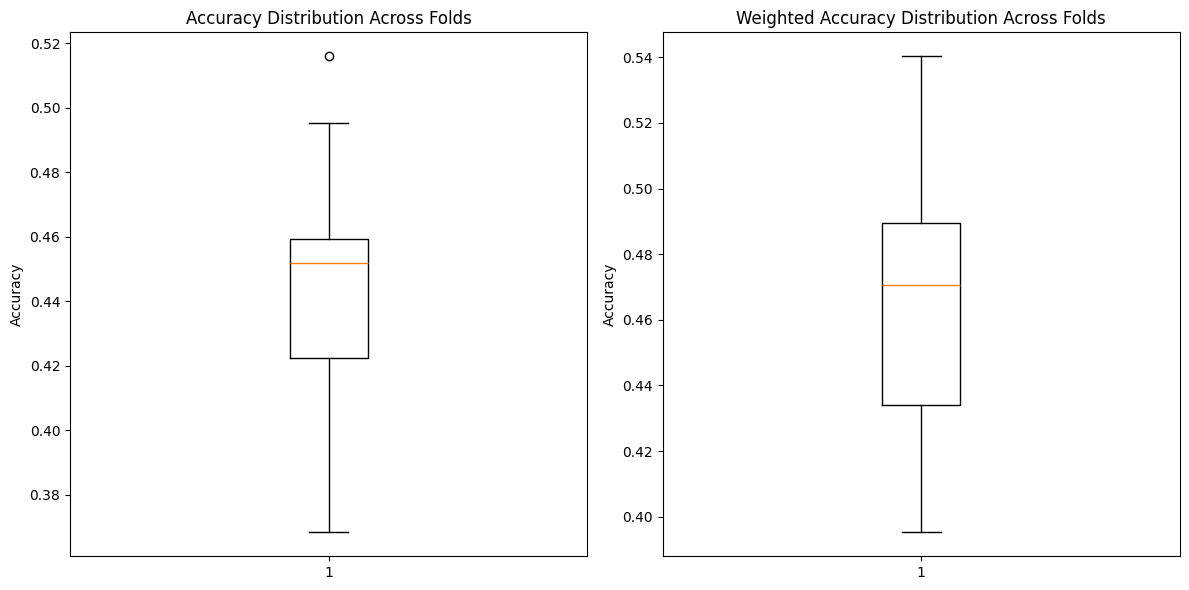

In [156]:
# Used to plot both side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot for accuracy
axes[0].boxplot(accuracy_list)
axes[0].set_title('Accuracy Distribution Across Folds')
axes[0].set_ylabel('Accuracy')

# Boxplot for weighted accuracy
axes[1].boxplot(weighted_accuracy_list)
axes[1].set_title('Weighted Accuracy Distribution Across Folds')
axes[1].set_ylabel('Accuracy')

# Display the plots side by side
plt.tight_layout()
plt.show()

In [157]:
def plot_confusion_matrices(confusion_matrix_list, class_labels=None, pair=1):
    # Determine the folds for the selected pair
    pair_start = (pair - 1) * 2  # Each pair consists of two folds
    pair_end = pair_start + 2
    
    # Extract the confusion matrices for the selected pair
    selected_cm = confusion_matrix_list[pair_start:pair_end]
    cols = 2  # Each pair consists of two folds (so 2 columns per pair)

    # Adjust figure size
    plt.figure(figsize=(10, 5))

    for i, cm in enumerate(selected_cm):
        plt.subplot(1, cols, i + 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
        plt.title(f'Confusion Matrix for Fold {pair_start + i + 1}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

    plt.tight_layout()
    plt.show()

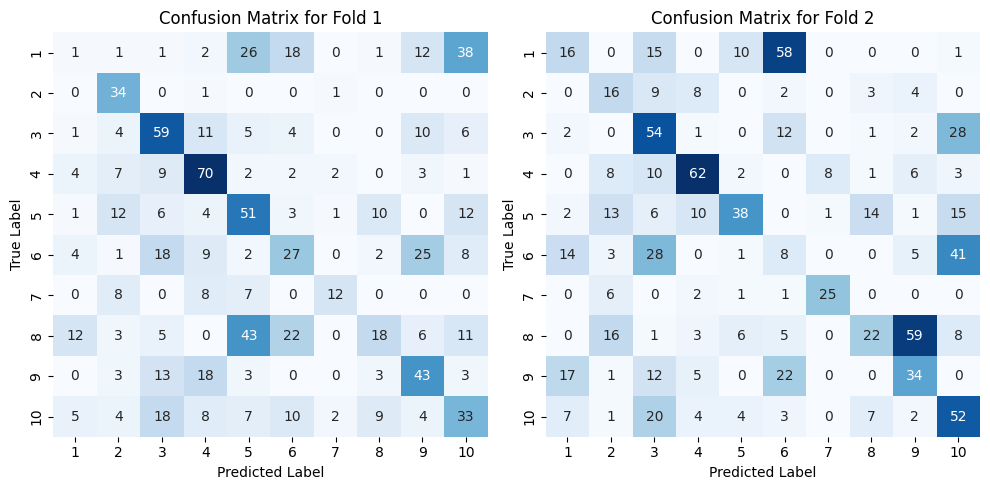

In [158]:

class_labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
plot_confusion_matrices(confusion_matrix_list, class_labels=class_labels, pair=1)

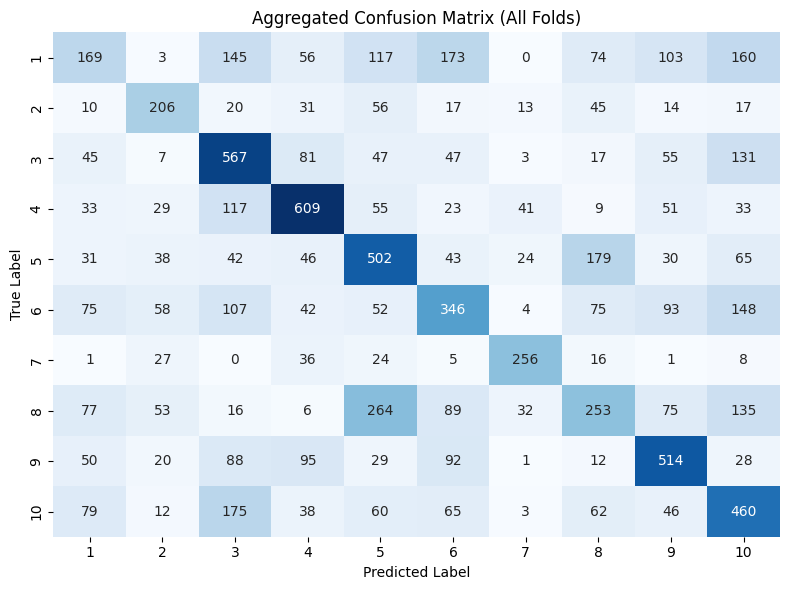

In [159]:
def plot_aggregated_confusion_matrix(confusion_matrix_list, class_labels=class_labels):
    # Aggregate all confusion matrices by summing them element-wise
    total_cm = np.sum(confusion_matrix_list, axis=0)

    # Plot the aggregated confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(total_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Aggregated Confusion Matrix (All Folds)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

plot_aggregated_confusion_matrix(confusion_matrix_list,class_labels)

### Second Model


In [161]:
# Easily configurable to generate with different architecture
# Implicitly creates first model, explained above

def generate_lstm(train_shape, lstm1_size=64, lstm2_size=32, dropout=0.2, regularization=0.001):
    # Initiaizes sequential model
    model = Sequential()

    # Adds 2 LSTM layers of size 128 and 64, with a dropout rate of 0.2
    model.add(layers.LSTM(lstm1_size,  input_shape = train_shape, return_sequences = True, activation='tanh'))
    model.add(layers.Dropout(dropout))
    model.add(layers.LSTM(lstm2_size, return_sequences = True, activation='tanh'))
    model.add(layers.Dropout(dropout))

    # Suggested intermediate dense layer -> reduce dimensionality and preserve time sequential features
    model.add(layers.TimeDistributed(layers.Dense(64, activation='tanh', kernel_regularizer = reg.l2(regularization))))
    model.add(layers.Dropout(dropout))
    model.add(layers.TimeDistributed(layers.Dense(32, activation='tanh', kernel_regularizer = reg.l2(regularization))))
    model.add(layers.Dropout(dropout))

    # Last TimeDistributed produces 16 features/time step (thought dimensionality was appropriate)
    model.add(layers.TimeDistributed(layers.Dense(16, activation='tanh', kernel_regularizer = reg.l2(regularization))))
    model.add(layers.Dropout(dropout))

    # Flattens the last TimeDistributed outputs
    model.add(layers.Flatten())

    # Dense output layer -> classification
    model.add(layers.Dense(10, activation = 'softmax'))

    return model

In [162]:
# Runs all folds
results = test_model(df_44, input_shape=SHAPE2, epochs=50, dropout=0.4, batch_size=16, end=2)

# Save the results to a pickle file for initial plotting
with open('results_lower_batch.pkl', 'wb') as f:
    pickle.dump(results, f)


Test fold 1
Epoch 1/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 47s 79ms/step - accuracy: 0.2287 - loss: 2.9787 - val_accuracy: 0.3313 - val_loss: 2.2439
Epoch 2/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.4090 - loss: 2.0236 - val_accuracy: 0.4303 - val_loss: 1.8817
Epoch 3/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.4723 - loss: 1.6511 - val_accuracy: 0.3828 - val_loss: 1.8073
Epoch 4/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.5344 - loss: 1.4185 - val_accuracy: 0.4232 - val_loss: 1.6622
Epoch 5/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.5824 - loss: 1.2458 - val_accuracy: 0.4515 - val_loss: 1.6818
Epoch 6/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.6439 - loss: 1.1071 - val_accuracy: 0.4566 - val_loss: 1.5925
Epoch 7/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 36s 85ms/step - accuracy: 0.6659 - loss: 0.9979 - val_accuracy: 0.4970 - val_loss: 1.6590
Epoch 8/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.6910 - los

KeyboardInterrupt: 

In [113]:
accuracy_list, weighted_accuracy_list = print_results(results)


Final Metrics Across All Folds:


Loss and F1 score: 

Average Loss: 3.0669
Loss Standard Deviation: 0.0000
Average F1 Score (Weighted): 0.4704
F1 Score Standard Deviation: 0.0000

Accuracies: 

Average Training Accuracy: 0.8595
Training Accuracy Standard Deviation: 0.0000
Average Validation Accuracy: 0.4591
Training Validation Standard Deviation: 0.0000
Average Test Accuracy: 0.4788
Test Accuracy Standard Deviation: 0.0000
Average Weighted Accuracy: 0.4966
Weighted Accuracy Standard Deviation: 0.0000


In [114]:
confusion_matrix_list = results[6]
                                                                                                                   
predictions_list, true_y_list = results[7:9]

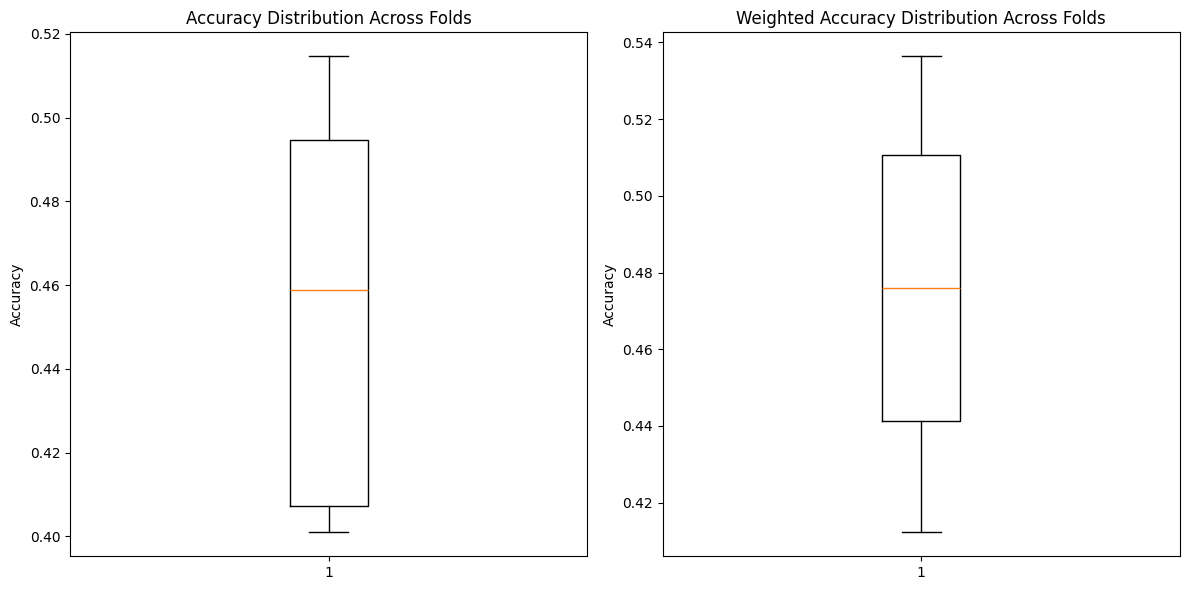

In [61]:
# Used to plot both side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot for accuracy
axes[0].boxplot(accuracy_list)
axes[0].set_title('Accuracy Distribution Across Folds')
axes[0].set_ylabel('Accuracy')

# Boxplot for weighted accuracy
axes[1].boxplot(weighted_accuracy_list)
axes[1].set_title('Weighted Accuracy Distribution Across Folds')
axes[1].set_ylabel('Accuracy')

# Display the plots side by side
plt.tight_layout()
plt.show()

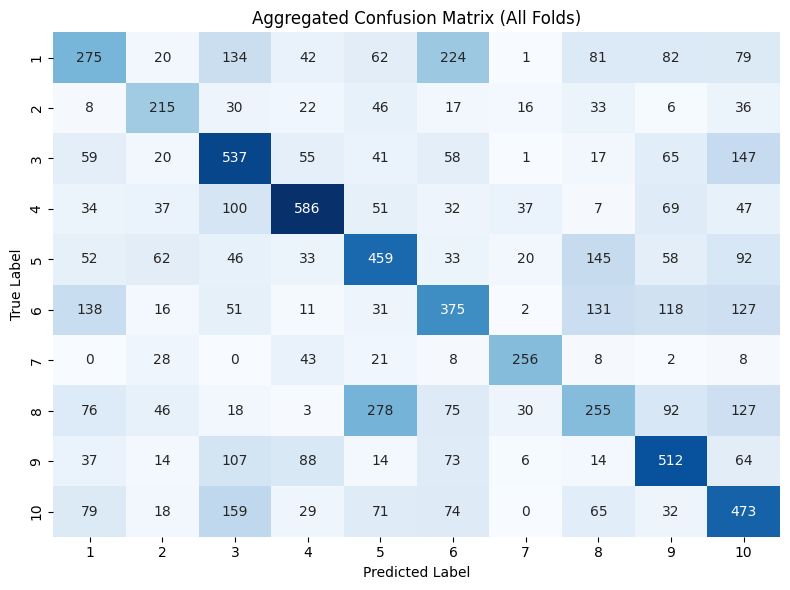

In [62]:
plot_aggregated_confusion_matrix(confusion_matrix_list,class_labels)

# Layer changes

see if it improves overfitting:

 - lstm2 size to 128
 - increased dropout to 0.4

# References

Introduction to Extraction of Data from the UrbanSound8k dataset - [part1](https://www.youtube.com/watch?v=mHPpCXqQd7Y), [part2](https://www.youtube.com/watch?v=4F-cwOkMdTE)

Many-to-Many LSTM for Sequence Prediction with TimeDistributed layers - [link](https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/)

